# Training an RNN to predict the weather at Purdue

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [24]:
data = pd.read_csv("purdue_weather.csv")
# Ensure DATE column is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

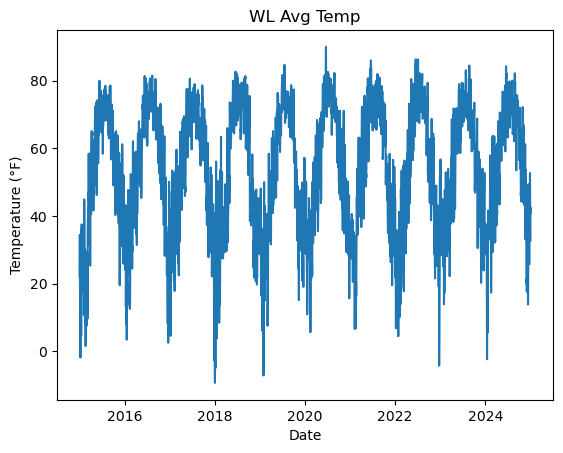

In [25]:
# Plot the TEMP column with DATE on the x-axis
plt.plot(data['DATE'], data['TEMP'])
plt.title('WL Avg Temp')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.show()

## Split Data

In [26]:
# Training loop
train = data[data['DATE'] < '2023-01-01']
test = data[data['DATE'] >= '2023-01-01']

x_train = np.array(train['TEMP'])[:-1]
y_train = np.array(train['TEMP'])[1:]

seq_length = 25


inputs = np.array([x_train[i:i+seq_length] for i in range(len(x_train) - seq_length)])
targets = np.array([y_train[i:i+seq_length] for i in range(len(y_train) - seq_length)])

## Define the model

In [27]:
# Define model parameters

H = 128 # RNN hidden size
learning_rate = 2e-4 # Learning rate for gradient descent

Wxh = np.random.randn(H, 1) * 0.01 # Input to hidden weights
Whh = np.random.randn(H, H) * 0.01 # Hidden to hidden weights
Why = np.random.randn(1, H) * 0.01 # Hidden to output weights
bh = np.zeros((H, 1)) # Hidden bias
by = np.zeros((1, 1)) # Output bias

## Forward Pass

In [28]:
# Forwarding one example through the RNN

input = inputs[0]
target = targets[0]

# initialize dictionaries for inputs, hidden states, and outputs in each time step
xs, hs, ys = {}, {}, {}
hs[-1] = np.copy(np.zeros((H, 1)))
loss = 0

# forward pass
for t in range(len(input)):
    xs[t] = input[t].reshape(-1, 1) # (1, 1)
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # (H, 1)
    ys[t] = np.dot(Why, hs[t]) + by # (1, 1)
    loss += (ys[t] - targets[t]) ** 2

loss = loss / len(input)

## Backward Pass

In [29]:
# backward pass

# initialize gradients
dWxh = np.zeros_like(Wxh) # (H, 1)
dWhh = np.zeros_like(Whh) # (H, H)
dWhy = np.zeros_like(Why) # (1, H)
dbh = np.zeros_like(bh) # (H, 1)
dby = np.zeros_like(by) # (1, 1)


# backpropagate through time
dhnext = np.zeros_like(hs[0])
for t in reversed(range(len(input))):
    dy = (ys[t] - target[t]) * 2 / len(input) # (1, 1)
    dWhy += np.dot(dy, hs[t].T) # (1, H)
    dby += dy # (1, 1)
    dh = np.dot(Why.T, dy) + dhnext # (H, 1)
    d_hpreact = (1 - hs[t] ** 2) * dh # (H, 1)
    dbh += d_hpreact # (H, 1)
    dWxh += np.dot(d_hpreact, xs[t].T) # (H, 1)
    dWhh += np.dot(d_hpreact, hs[t-1].T) # (H, H)
    dhnext = np.dot(Whh.T, d_hpreact) # (H, 1)

    

## Putting it together

In [30]:
# Warp it all in a function so we can call it repeatedly for each example and update the parameters

def loss_fn(input, target, h_init):
    xs, hs, ys = {}, {}, {}
    hs[-1] = np.copy(h_init)
    loss = 0

    # forward pass
    for t in range(len(input)):
        xs[t] = input[t].reshape(-1, 1) # (1, 1)
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # (H, 1)
        ys[t] = np.dot(Why, hs[t]) + by # (1, 1)
        loss += (ys[t] - target[t]) ** 2
    loss = loss / len(input)
    # loss += 0.5 * (np.sum(Wxh ** 2) + np.sum(Whh ** 2) + np.sum(Why ** 2)) # L2 regularization
    
    # backward pass
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(input))):
        dy = (ys[t] - target[t]) * 2 / len(input)
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        d_hpreact = (1 - hs[t] ** 2) * dh
        dbh += d_hpreact
        dWxh += np.dot(d_hpreact, xs[t].T)
        dWhh += np.dot(d_hpreact, hs[t-1].T)
        dhnext = np.dot(Whh.T, d_hpreact)
    # clip gradients to prevent vanishing/exploding gradients
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)
    return loss, [dWxh, dWhh, dWhy, dbh, dby], ys[len(input)-1]


## Training Loop

In [31]:
# Training loop

for epoch in range(10):
    h_init = np.zeros((H, 1))
    for i in range(len(inputs)):
        loss, grads, pred = loss_fn(inputs[i], targets[i], h_init)
        if i % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
        for param, grad in zip([Wxh, Whh, Why, bh, by], grads):
            param -= learning_rate * grad
    print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: [[654.56890436]]
Epoch 0, Loss: [[1715.5333118]]
Epoch 0, Loss: [[2148.68447539]]
Epoch 0, Loss: [[144.74152205]]
Epoch 0, Loss: [[60.50739396]]
Epoch 0, Loss: [[301.93162729]]
Epoch 0, Loss: [[96.26382197]]
Epoch 0, Loss: [[64.40724142]]
Epoch 0, Loss: [[48.58932362]]
Epoch 0, Loss: [[50.10403126]]
Epoch 0, Loss: [[23.26686919]]
Epoch 0, Loss: [[104.27818476]]
Epoch 0, Loss: [[77.64277677]]
Epoch 0, Loss: [[15.20541898]]
Epoch 0, Loss: [[29.33943044]]
Epoch 0, Loss: [[40.60077641]]
Epoch 0, Loss: [[17.4136648]]
Epoch 0, Loss: [[18.98571225]]
Epoch 0, Loss: [[47.21838169]]
Epoch 0, Loss: [[49.94158313]]
Epoch 0, Loss: [[9.74797226]]
Epoch 0, Loss: [[42.77801016]]
Epoch 0, Loss: [[30.05539384]]
Epoch 0, Loss: [[35.65837192]]
Epoch 0, Loss: [[9.14650212]]
Epoch 0, Loss: [[58.84475231]]
Epoch 0, Loss: [[67.92495152]]
Epoch 0, Loss: [[23.25158988]]
Epoch 0, Loss: [[27.62708529]]
Epoch 0, Loss: [[75.55212875]]
Epoch 1, Loss: [[80.97356916]]
Epoch 1, Loss: [[19.62829061]]
Epoc

## Test the model

Average Test Loss: [[227.59208819]]


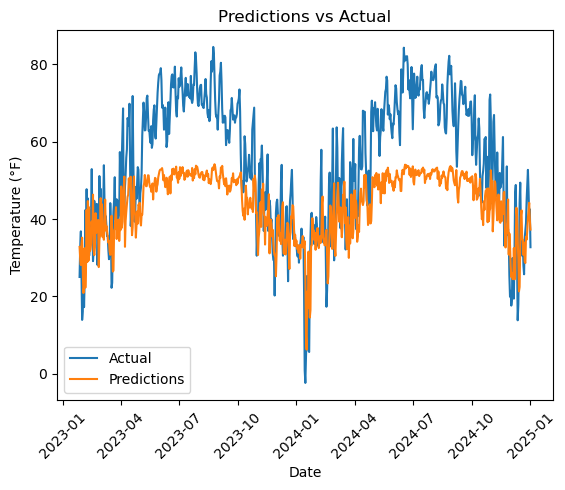

In [35]:
# Test the model

x_test = np.array(test['TEMP'])[:-1]
y_test = np.array(test['TEMP'])[1:]

inputs_test = np.array([x_test[i:i+seq_length] for i in range(len(x_test) - seq_length)])
targets_test = np.array([y_test[i:i+seq_length] for i in range(len(y_test) - seq_length)])

h_init = np.zeros((H, 1))
predictions = []
avg_test_loss = 0
for i in range(len(inputs_test)):
    loss, _, pred = loss_fn(inputs_test[i], targets_test[i], h_init)
    avg_test_loss += loss
    predictions.append(pred[0][0])
avg_test_loss /= len(inputs_test)
# Plot predictions vs actual
plt.plot(test['DATE'][seq_length+1:], y_test[seq_length:], label='Actual')
plt.plot(test['DATE'][seq_length+1:], predictions, label='Predictions')
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Temperature (°F)')
plt.legend()
print(f'Average Test Loss: {avg_test_loss}')